### Import Libraries

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from skimage.metrics import structural_similarity as ssim


import os
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Utils/Functions

In [104]:
class vae_scratch(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),

            nn.Conv2d(32, 64, 3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Flatten()
        )

        self.z_mean = nn.Linear(1600,160)
        self.z_sd = nn.Linear(1600,160)

        self.decoder = nn.Sequential(
            nn.Linear(160,1600),
            nn.Unflatten(1, (64, 5, 5)),

            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(64,32,4,stride=1),
            nn.BatchNorm2d(32),
            nn.GELU(),

            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(32,16,3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),

            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(16,1,3,stride=1,padding=1),
            nn.Tanh()
        ) 

    def encoding_from_reparam(self,x):
        x = self.encoder(x)
        z_mean, z_sd = self.z_mean(x), self.z_sd(x)
        x_latent = self.reparameterization(z_mean,z_sd)
        return x_latent, z_mean, z_sd

    def reparameterization(self,z_mu,z_sd):
        eps = torch.randn_like(z_mu).cuda()
        z = z_mu + eps * torch.exp(z_sd * 0.5)
        return z

    def forward(self,x_latent):
        x_latent, z_mean, z_sd = self.encoding_from_reparam(x_latent)
        x_decode = self.decoder(x_latent)
        return x_latent, z_mean, z_sd, x_decode



def training_loop(model,epochs,dataloader_train,criterion,optimizer,device):
    loss_track=[]

    for epoch in range(0,epochs):
        loss_item = 0
        for img,_ in train_loader:
            img = img.to(device)
            
            optimizer.zero_grad()

            out_latent, z_mean, z_sd, out_decode = model(img)
            kl_div = -0.5 * torch.sum(1 + z_sd - z_mean**2 - torch.exp(z_sd), axis=1)
            batchsize = kl_div.size(0)
            kl_div = kl_div.mean()
            
            pixelwise = criterion(out_decode,img,reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean()
            loss = 1*pixelwise + kl_div

            loss.backward()
            optimizer.step()

        if epoch%1==0 or epoch%2==0:
            print(f'Epoch={epoch} and Loss={loss.item():.4f}')
        loss_track.append(loss.item())

    return loss_track

def evaluate_model(model, dataloader_test, device):
    pass


### Load Data from Library

In [10]:
if os.path.exists("./data/FashionMNIST"):
    train_set = torchvision.datasets.FashionMNIST("./data", download=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=False, train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))  
else:
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=16)

### Visualize the Dataset

Testing Image Diemnsions:--
torch.Size([128, 1, 28, 28]) torch.Size([128])


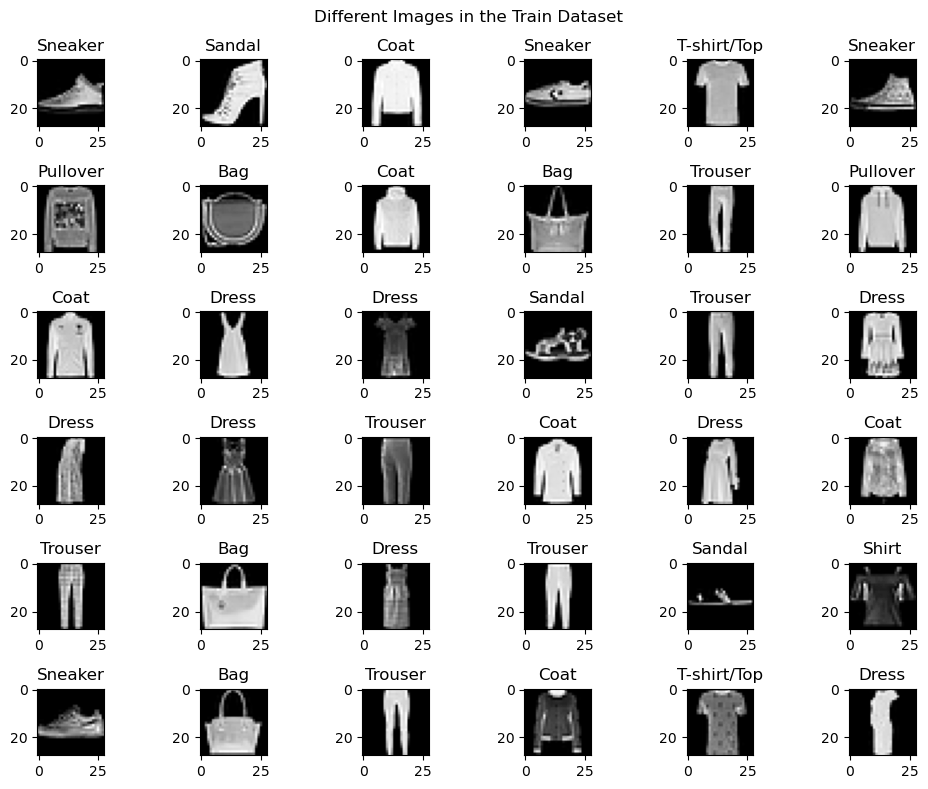

In [11]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

img,lab = next(iter(train_loader))
print('Testing Image Diemnsions:--')
print(img.shape, lab.shape)

plt.figure(figsize=(10,8))
for i in range(0,36):
    plt.subplot(6,6,i+1)
    plt.imshow(img[i].squeeze(), cmap='gray')
    plt.title(output_label(lab[i]))
plt.suptitle('Different Images in the Train Dataset')
plt.tight_layout()

### Train the Model & Check Loss Function

#### Experimental Notes 1
- I tried running the model for different activation functions (Leaky RELU, RELU) but didn't see marked difference in the loss curve. I did not change the architecture or the learning rate (1e-4).
- I changed the architecture, added a new convolution layer to see if the training is smoother. Increased the learning rate to 1e-3. The loss curve was more stochastic and the loss did reduce but went back up, seems like it is overshooting.
- Reducing the loss to 1e-5 gave a much stable loss curve and training. But the loos didnt decrease too much indicating more number of epochs will be needed to train it. Thus going back to 1e-4.
- Having LR 1e-2 was no good. LR of 5e-4 is also not that good.
- Adding Droput didnt help in the trianing. Reduced the model loss.

In [105]:
torch.cuda.empty_cache()

num_epochs = 50

model = vae_scratch().to(device)
criterion = F.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_track = training_loop(model,num_epochs,train_loader,criterion,optimizer,device)


Epoch=0 and Loss=127.1789
Epoch=1 and Loss=111.5678
Epoch=2 and Loss=96.8413
Epoch=3 and Loss=84.6554
Epoch=4 and Loss=90.3052
Epoch=5 and Loss=78.2011
Epoch=6 and Loss=83.6950
Epoch=7 and Loss=80.6068
Epoch=8 and Loss=82.1441
Epoch=9 and Loss=76.1411
Epoch=10 and Loss=76.6173
Epoch=11 and Loss=77.9224
Epoch=12 and Loss=68.9934
Epoch=13 and Loss=70.5058
Epoch=14 and Loss=75.0073
Epoch=15 and Loss=73.0758
Epoch=16 and Loss=65.6166
Epoch=17 and Loss=73.7501
Epoch=18 and Loss=74.6463
Epoch=19 and Loss=68.5665
Epoch=20 and Loss=72.2017
Epoch=21 and Loss=70.0381
Epoch=22 and Loss=71.4781
Epoch=23 and Loss=65.2271
Epoch=24 and Loss=67.0100
Epoch=25 and Loss=68.2494
Epoch=26 and Loss=65.0751
Epoch=27 and Loss=66.8152
Epoch=28 and Loss=67.1089
Epoch=29 and Loss=67.9429
Epoch=30 and Loss=70.3051
Epoch=31 and Loss=66.7611
Epoch=32 and Loss=65.7951
Epoch=33 and Loss=64.1231
Epoch=34 and Loss=70.4697
Epoch=35 and Loss=65.3860
Epoch=36 and Loss=68.4172
Epoch=37 and Loss=66.3453
Epoch=38 and Loss=61

Text(0.5, 1.0, 'Loss of Basic CNN Autoencoder')

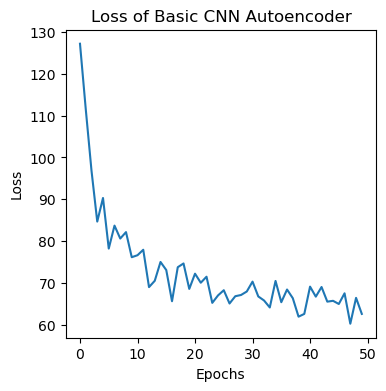

In [106]:
plt.figure(figsize=(4,4))
plt.plot(loss_track)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss of Basic CNN VAE')

### Visualize on the Test Dataset for Reconstruction

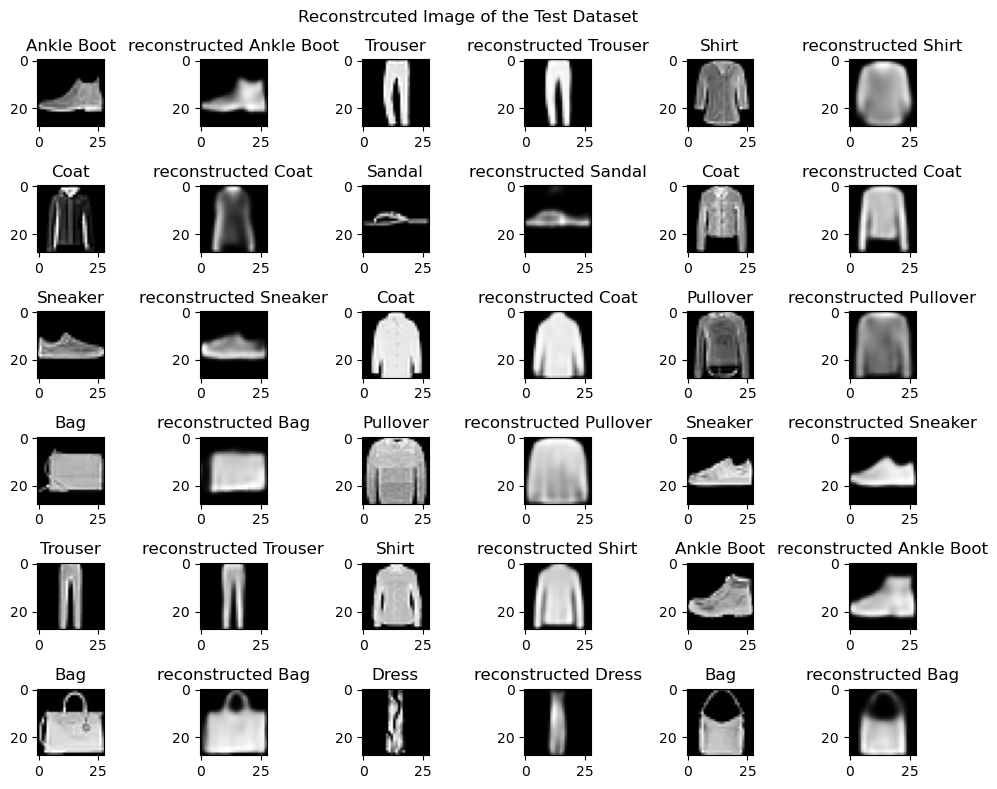

In [107]:
model.eval()
test_img,test_lab = next(iter(test_loader))

_,_,_,recon_img = model(test_img.to(device))

plt.figure(figsize=(10,8))
for i in range(0,36,2):
    plt.subplot(6,6,i+1)
    plt.imshow(test_img[i].squeeze(), cmap='gray')
    plt.title(output_label(test_lab[i]))
    
    plt.subplot(6,6,i+2)
    plt.imshow(recon_img[i].squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title(f'reconstructed {output_label(test_lab[i])}')
    if i+2==36:
        break

plt.suptitle('Reconstrcuted Image of the Test Dataset')
plt.tight_layout()

### Latent Space Distribution Visualization

Mean of Latent Space:  tensor(-0.0008, device='cuda:0')
SD of Latent Space:  tensor(0.9987, device='cuda:0')


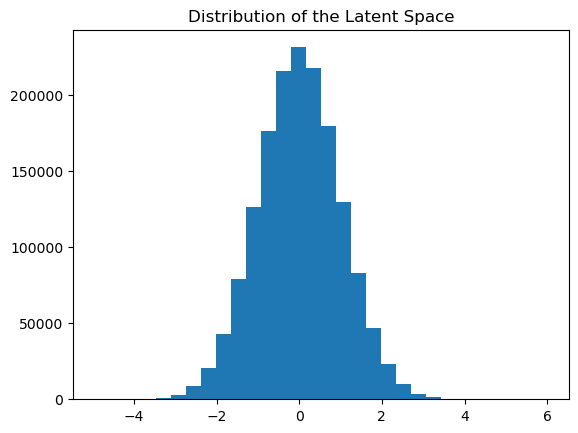

In [108]:
model.eval()

all_latent_space = []
all_labels = []
for img,labels in test_loader:
    img = img.to(device)
    latent_space_test, _, _, _ = model(img)
    
    all_latent_space.append(latent_space_test.detach())
    all_labels.append(labels)

all_labels = torch.cat(all_labels,dim=0)

all_latent_space = torch.cat(all_latent_space, dim=0)
all_latent_space_flat = all_latent_space.flatten()

print('Mean of Latent Space: ', all_latent_space_flat.mean())
print('SD of Latent Space: ', all_latent_space_flat.std())
plt.hist(all_latent_space_flat.detach().cpu().numpy(),bins=30)
plt.title('Distribution of the Latent Space')
plt.show()


### New Images from Random Vectors of Standard Normal Distribution

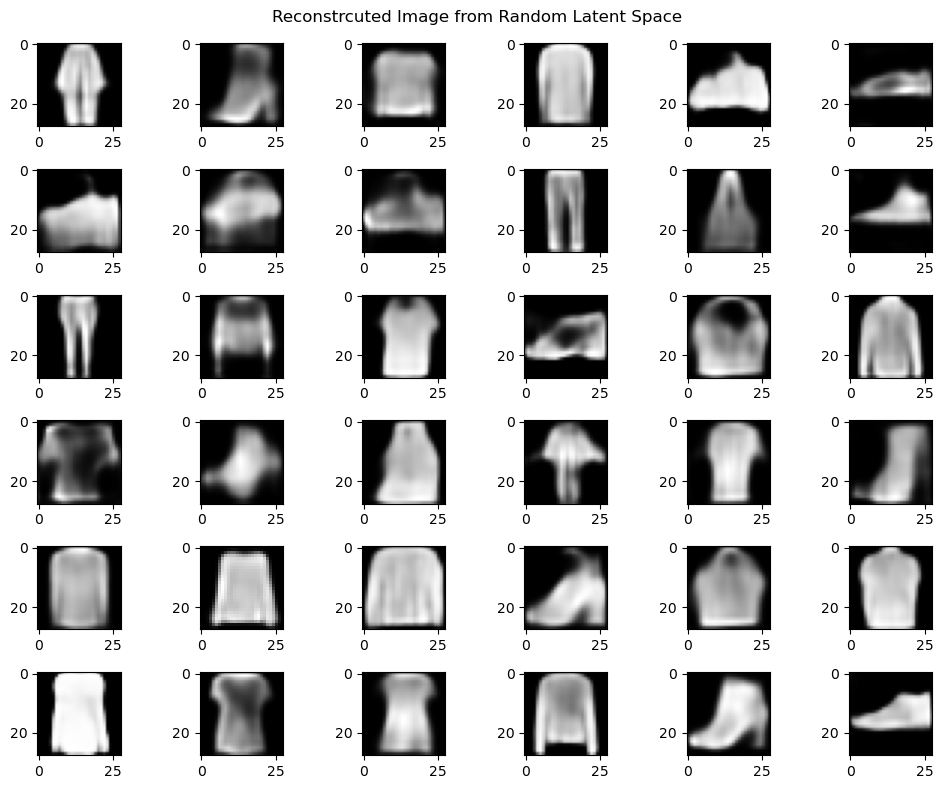

In [109]:
model.eval()
temp = torch.randn_like(all_latent_space[0:36])
output_gen_images = model.decoder(temp.to(device)) 

plt.figure(figsize=(10,8))
for i in range(0,36):
    plt.subplot(6,6,i+1)
    plt.imshow(output_gen_images[i].squeeze().detach().cpu().numpy(), cmap='gray')

plt.suptitle('Reconstrcuted Image from Random Latent Space')
plt.tight_layout()


### Latent space interpolation: Encoding two different test images, linearly in-terpolating between their latent vectors, and decode each intermediate point

Text(0.5, 0.98, 'randomly selecting two images')

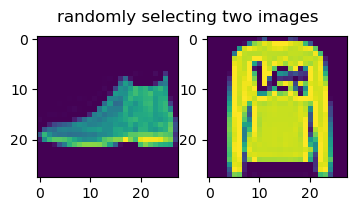

In [110]:
## Encoding two different test images
test_images_batch,_ = next(iter(test_loader))
test_images_samples = test_images_batch[:2]

plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.imshow(test_images_samples[0][0])
plt.subplot(1,2,2)
plt.imshow(test_images_samples[1][0])
plt.suptitle('randomly selecting two images')

Encoded Two Image Dim: torch.Size([2, 160])


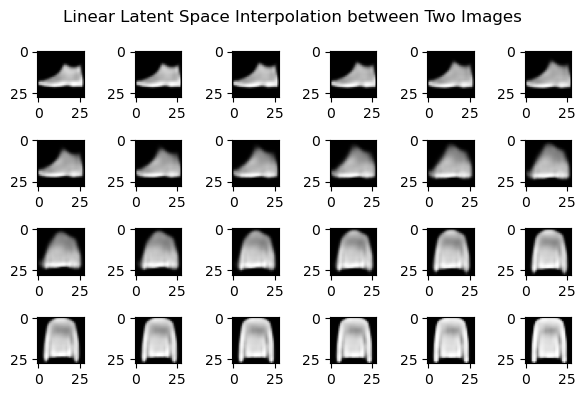

In [111]:
def linear_interpolation(model, start, end, steps):
    # For every step linearly interpolating the latent space vector along the path of the interpolation
    z = (torch.linspace(0, 1, steps)[:, None].to(device) * (end - start)) + start
    
    model.eval()
    with torch.no_grad():
      samples = model.decoder(z)
    return samples


test_images_encode, _, _ = model.encoding_from_reparam(test_images_samples.to(device))
print('Encoded Two Image Dim:', test_images_encode.shape)
start = test_images_encode[0]
end = test_images_encode[1]
interpolated_samples = linear_interpolation(model, start, end, steps = 24)

plt.figure(figsize=(6,4))
for i in range(0,24):
    plt.subplot(4,6,i+1)
    plt.imshow(interpolated_samples[i].squeeze().detach().cpu().numpy(), cmap='gray')

plt.suptitle('Linear Latent Space Interpolation between Two Images')
plt.tight_layout()


### Systematically vary each latent space dimension one at a time in the range [−3, 3], keeping all other dimensions fixed. Decode each modified latent vector and visualize the corresponding images.

- Took a sample Test Image - Tshirt
- Ran a loop for 10 steps to update a particular latent dimension with 10 different values ranginf between -3 to 3.
- Ran multiple loops for all individual dimensions (in this case latent space diemsnion is 160, therefore ran a loop for 160 times 10 to update every diemnsion for 10 different values ranging between -3 to 3)
- Found that Diemsnion 55th has a paricular feature which is causing the thsirt to look more like shirt and then more like a hoodie if we change the diemnsions value linearly between -3 to 3.

In [161]:
def systematic_varying_of_latent_sapce(latent_space dims):
    steps=10
    latent_update = torch.linspace(-3, 3, steps)
    new_latent = []

    for dim in range(dims,dims+1):
        for i in range(0,steps):
            latent_space_copy = latent_space.clone()
            latent_space_copy[0,dim] = latent_update[i]
            new_latent.append(latent_space_copy)

    return torch.cat(new_latent,dim=0)


test_images_batch,_ = next(iter(test_loader))
test_images_samples = test_images_batch[1].unsqueeze(0)
print('Sample Dim: ', test_images_samples.shape)

test_images_encode, _, _ = model.encoding_from_reparam(test_images_samples.to(device))
print(test_images_encode.shape,test_images_encode.max(),test_images_encode.min())

new_latent = systematic_varying_of_latent_sapce(test_images_encode,55)
print('New Latent Dim: ', new_latent.shape)

model.eval()
with torch.no_grad():
    new_imgs = model.decoder(new_latent)

print('New Images Dim: ', new_imgs.shape)

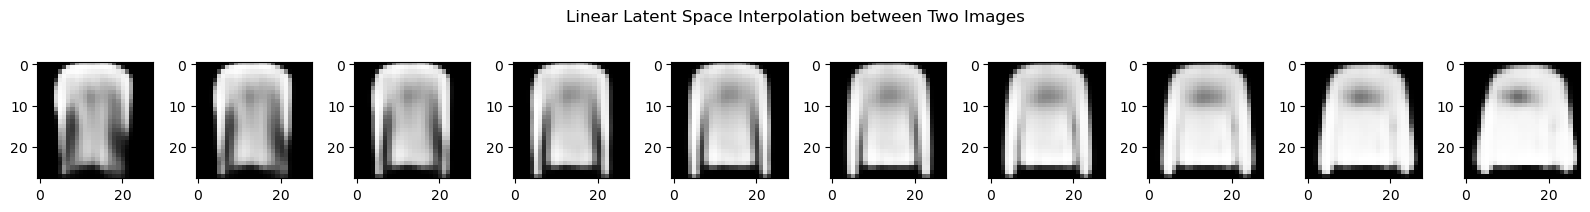

In [165]:
plt.figure(figsize=(16,2))
c=1
for i in range(10):
    plt.subplot(1,10,c)
    plt.imshow(new_imgs[i].squeeze().detach().cpu().numpy(), cmap='gray')
    c+=1

plt.suptitle('Linear Latent Space Interpolation between Two Images')
plt.tight_layout()

### Systamatic Varying of the all the latent space for a a prticular Fashion cateogry
- In this experiment I have updated the code to take a single fashion category and modify the each latent space one by one in the range of -3 to 3.
- Since there are 160 dimensions and the modification of the latent space is done in 10 steps of the range -3 to 3 therefore
- I am suing structural similarity metric to find which decoded image is considerably different from the original image. 
- Below I am showing all those images for which the result is different form the original image indiciating
- there are particular latent space diemnsions which can control the actual image appearance and therefore corresponds to strong eigen vectors of the image data 

In [183]:

def systematic_varying_of_all_latent_sapce(latent_space):
    steps=10
    latent_update = torch.linspace(-3, 3, steps)
    new_img = []
    similarity_list = []
    model.eval()
    with torch.no_grad():
        img2 = model.decoder(latent_space.to(device))

    for dim in range(0,latent_space.shape[1]):
        for i in range(0,steps):
            latent_space_copy = latent_space.clone()
            latent_space_copy[0,dim] = latent_update[i]

            model.eval()
            with torch.no_grad():
                img1 = model.decoder(latent_space_copy.to(device))
            
            img1_np = img1.squeeze().detach().cpu().numpy()
            img2_np = img2.squeeze().detach().cpu().numpy()
            ssim_val = ssim(img1_np, img2_np, data_range=img2_np.max() - img2_np.min())

            similarity_list.append(ssim_val)
            new_img.append(img1)


    return torch.cat(new_img,dim=0), torch.tensor(similarity_list)
    
    
new_img,similarity_list = systematic_varying_of_all_latent_sapce(test_images_encode)

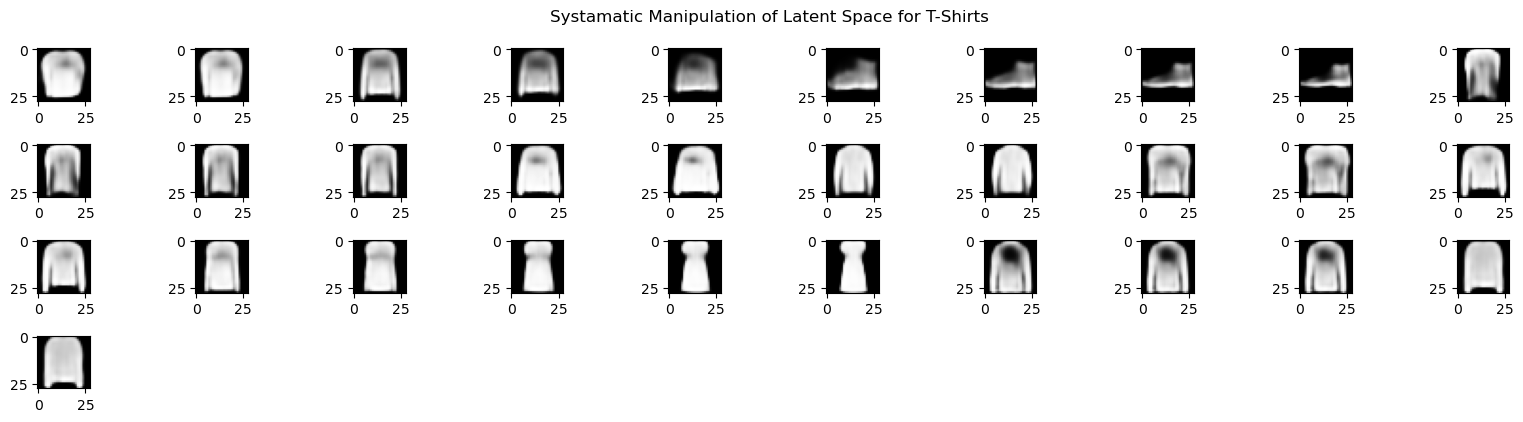

In [200]:
plt.figure(figsize=(16,5))
c=1
for i in list(np.where(similarity_list<0.6)[0]):
    plt.subplot(5,10,c)
    plt.imshow(new_img[i].squeeze().detach().cpu().numpy(), cmap='gray')
    c+=1

plt.suptitle('Systamatic Manipulation of Latent Space for T-Shirts')
plt.tight_layout()